In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
takehome_users_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859*1',
                               index_col='object_id')
takehome_users_df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
takehome_users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


In [4]:
takehome_users_df.describe()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [5]:
takehome_user_engagement_df = pd.read_csv('takehome_user_engagement.csv',
                                          parse_dates=['time_stamp'],
                                          index_col='time_stamp')
takehome_user_engagement_df = takehome_user_engagement_df.sort_index()
takehome_user_engagement_df.head()

,user_id,visited
time_stamp,,
2012-05-31 08:20:06,10012,1
2012-05-31 15:47:36,3428,1
2012-05-31 17:19:37,9899,1
2012-05-31 21:58:33,1693,1
2012-06-01 00:17:30,6102,1


In [6]:
for user in takehome_users_df.index.unique():
    user_df = takehome_user_engagement_df[takehome_user_engagement_df['user_id']==user].resample('1W').count().copy()
    if len(user_df[user_df.visited >=3]) >= 1:
        takehome_users_df.at[user, 'adopted_user'] = 1
    else:
        takehome_users_df.at[user, 'adopted_user'] = 0

In [7]:
takehome_users_df.columns

Index(['creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user'],
      dtype='object')

In [8]:
takehome_users_df.drop(columns=['creation_time', 'name', 'email',
                               'org_id', 'last_session_creation_time'],
                       inplace=True)

In [9]:
# Change invited_by_user_id to binary yes or no
takehome_users_df['invited'] = takehome_users_df['invited_by_user_id'] > 0
takehome_users_df['invited'] = takehome_users_df['invited'].apply(int)
takehome_users_df.drop(columns='invited_by_user_id', inplace=True)

In [10]:
int_df = pd.get_dummies(takehome_users_df)

In [11]:
int_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
adopted_user                          12000 non-null float64
invited                               12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
dtypes: float64(1), int64(3), uint8(5)
memory usage: 847.3 KB


This is a classification problem. I want to know which factors predict future user adoption so I am going to use a RandomForestClassifier to determine which features are most important.
   

In [12]:
from sklearn.ensemble import RandomForestClassifier

features = int_df.loc[:, int_df.columns != 'adopted_user']
target = int_df['adopted_user']

rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(features, target)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
rfc.feature_importances_

array([0.09656828, 0.08666536, 0.06636101, 0.11897447, 0.08269638,
       0.37095726, 0.06851699, 0.10926025])

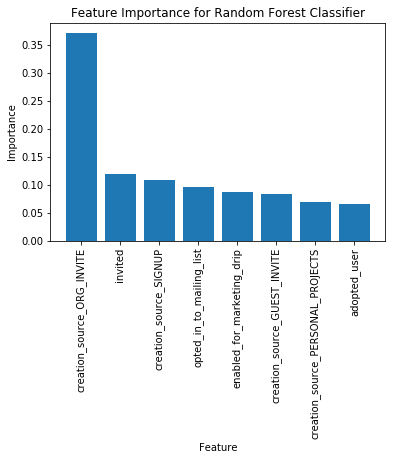

In [14]:
indices = np.argsort(rfc.feature_importances_)[::-1]
_ = plt.bar(int_df.columns[indices], rfc.feature_importances_[indices])
_ = plt.title('Feature Importance for Random Forest Classifier')
_ = plt.xlabel('Feature')
_ = plt.ylabel('Importance')
_ = plt.xticks(rotation=90)